In [1]:
import gymnasium as gym
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
from tqdm import tqdm
import os
os.chdir('..')

# Multi Agent DDPG (MADDPG)

[Original Paper](https://arxiv.org/pdf/1706.02275.pdf)

[Implementation here](../scripts/maddpg.py)

- In multi-agent scenarios, training each individual agent using traditional RL methods often results in poor performance. Each agent's policy constantly changes during the training period, leading to a non-stationary environment from the perspective of any individual agent. Thus, the straightforward use of experience replay causes highly unstable learning.
- Multi Agent DDPG (MADDPG) addresses the non-stationary problem by centralizing experiences gathered by all agents during training while keeping learned policies local such that each agent only uses its own observations to act during execution.

- Given $N$ agents, with individual deterministic policies $\mu=\{\mu_1, ...,\mu_N\}$ parameterized by $\theta={\theta_1,...,\theta_N}$ that output individual actions $a_1, ..., a_N$ given their individual observations $o_1,...o_N$, the deterministic policy gradient (gradient of the expected return: $J(\theta_i)=\mathbb{E}[R_i]$) for agent $i$ is:
$$\nabla_{\theta_i}J(\mu_i)=\mathbb{E}_{x,a\sim\mathcal{D}}\left[\nabla_{\theta_i}\mu_i(a_i|o_i)\nabla_{a_i}Q_i^\mu(x,a_1,...,a_N)|_{a_i=\mu_i(o_i)}\right]$$
- $Q_i^\mu(x,a_1,...,a_N)$ is a *centralized action-value function* that each agent $i$ maintains. The inputs of $Q_i^\pi$ include the actions of all agents, $a_1, ..., a_N$, and some global state information $x$, that can consist of the observations of all agents, $x=(o_1,...,o_N)$, at a baseline, but also include additional state information if available.
  - The experience replay buffer $\mathcal{D}$ contains tuples of $(x, x', a_1, ..., a_N, r_1, ..., r_N)$ representing shared experiences of all agents.
- The critic $Q_i^\mu$ is updated using the target value: $$y=r_i+\gamma Q_i^{\mu'}(x',a_1', ..., a_N')|_{a_j'=\mu_j'(o_j)}$$
  - where $Q_i^{\mu'}(x',a_1', ..., a_N')$ refers to the output of the agent $i$'s target value network, using the actions, $a_1', ..., a_N'$, for the next state $x'$ selected by the target policy networks of each agent, $\mu'=\{\mu_1', ..., \mu_N'\}$.
- By conditioning on the actions of other agents, the environment is stationary even as policies change.

![maddpg](maddpg.png)

# Demos

## Speaker Listener

In [7]:
import pickle
from scripts.maddpg import FCDP, FCTQV
res = {}
with open('testfiles/maddpg_speakerlistener.results', 'rb') as file:
    res = pickle.load(file)

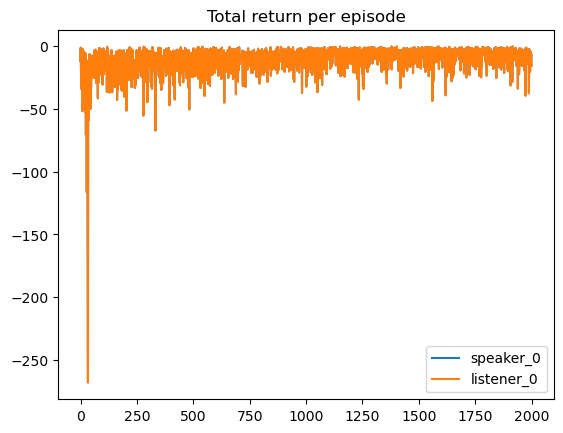

In [3]:
episode_returns = res['episode_returns']
for agent, returns in episode_returns.items():
    plt.plot(range(len(returns)), returns, label=f'{agent}')
plt.title('Total return per episode')
#plt.ylim(bottom=-50, top=0)
plt.legend()

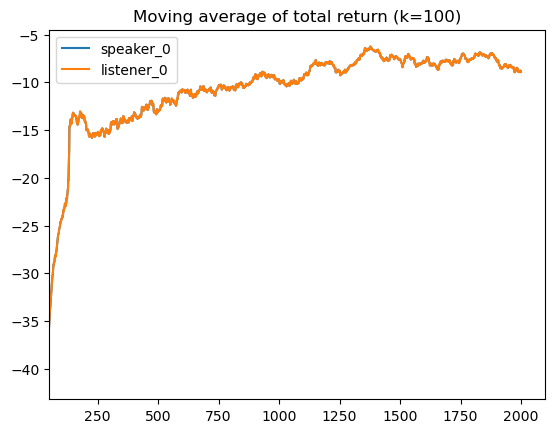

In [6]:
episode_returns = res['episode_returns']
for agent, returns in episode_returns.items():
    plt.plot(range(len(returns)), [np.mean(returns[max(0,x-100):x+1]) for x in range(len(returns))], label=f'{agent}')
plt.title('Moving average of total return (k=100)')
#plt.ylim(bottom=-50, top=0)
plt.xlim(left=50)
plt.legend()

In [7]:
from pettingzoo.mpe import simple_speaker_listener_v4
#from pettingzoo.mpe import simple_reference_v3
env = simple_speaker_listener_v4.env(max_cycles=25, continuous_actions=True, render_mode="human")
for _ in range(10):
    env.reset()
    ep_return = {agent : 0 for agent in env.possible_agents}
    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        ep_return[agent] += reward
        if termination or truncation:
            action = None
        else:
            # this is where you would insert your policy
            #action = env.action_space(agent).sample()
            action = res['best_model'][agent].select_action(observation)
        env.step(action)
    print(ep_return)
env.close()

{'speaker_0': -25.979047575785977, 'listener_0': -25.979047575785977}
{'speaker_0': -6.126248579174038, 'listener_0': -6.126248579174038}
{'speaker_0': -23.05633952297658, 'listener_0': -23.05633952297658}
{'speaker_0': -2.6002362606705742, 'listener_0': -2.6002362606705742}
{'speaker_0': -4.679797005338816, 'listener_0': -4.679797005338816}
{'speaker_0': -0.47070939170852294, 'listener_0': -0.47070939170852294}
{'speaker_0': -7.298809408847522, 'listener_0': -7.298809408847522}
{'speaker_0': -4.182602753130762, 'listener_0': -4.182602753130762}
{'speaker_0': -20.389631545795698, 'listener_0': -20.389631545795698}
{'speaker_0': -1.061177841551397, 'listener_0': -1.061177841551397}


In [14]:
from pettingzoo.mpe import simple_speaker_listener_v4
from gymnasium.utils.save_video import save_video
#from pettingzoo.mpe import simple_reference_v3
env = simple_speaker_listener_v4.env(max_cycles=25, continuous_actions=True, render_mode="rgb_array")
frames = []
for _ in range(10):
    env.reset()
    ep_return = {agent : 0 for agent in env.possible_agents}
    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        frames.append(env.render())
        ep_return[agent] += reward
        if termination or truncation:
            action = None
        else:
            # this is where you would insert your policy
            #action = env.action_space(agent).sample()
            action = res['best_model'][agent].select_action(observation)
        env.step(action)
    print(ep_return)
save_video(frames, "recordings/maddpg", fps=env.metadata["render_fps"], name_prefix='maddpg_speakerlistener')
env.close()

{'speaker_0': -7.344643479248482, 'listener_0': -7.344643479248482}
{'speaker_0': -7.68679903942981, 'listener_0': -7.68679903942981}
{'speaker_0': -16.0053103378489, 'listener_0': -16.0053103378489}
{'speaker_0': -1.3924889777312108, 'listener_0': -1.3924889777312108}
{'speaker_0': -6.303221641107429, 'listener_0': -6.303221641107429}
{'speaker_0': -5.381172548486729, 'listener_0': -5.381172548486729}
{'speaker_0': -6.141339161791756, 'listener_0': -6.141339161791756}
{'speaker_0': -1.9105646790379929, 'listener_0': -1.9105646790379929}
{'speaker_0': -3.209767020237008, 'listener_0': -3.209767020237008}
{'speaker_0': -15.046308631697242, 'listener_0': -15.046308631697242}
Moviepy - Building video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\maddpg/maddpg_speakerlistener-episode-0.mp4.
Moviepy - Writing video c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\maddpg/maddpg_speakerlistener-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\jimal\OneDrive\Documents\AI\reinforcement-learning\recordings\maddpg/maddpg_speakerlistener-episode-0.mp4


## Reference

In [2]:
import pickle
from scripts.maddpg import FCDP, FCTQV
res = {}
with open('testfiles/maddpg_reference1.results', 'rb') as file:
    res = pickle.load(file)

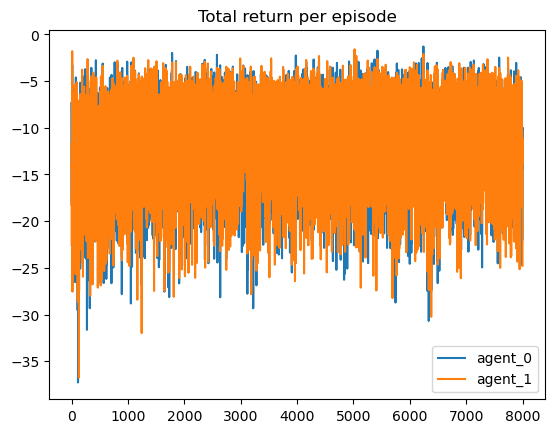

In [3]:
episode_returns = res['episode_returns']
for agent, returns in episode_returns.items():
    plt.plot(range(len(returns)), returns, label=f'{agent}')
plt.title('Total return per episode')
#plt.ylim(bottom=-50, top=0)
plt.legend()

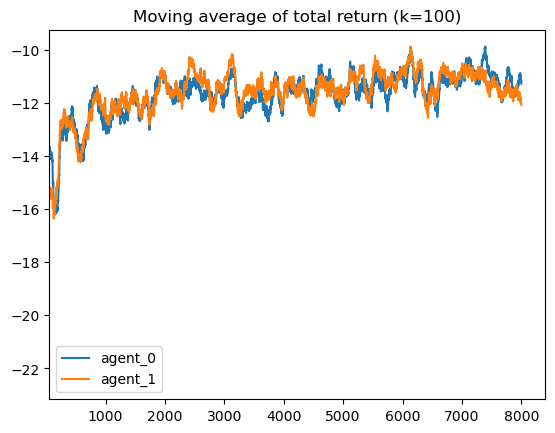

In [4]:
episode_returns = res['episode_returns']
for agent, returns in episode_returns.items():
    plt.plot(range(len(returns)), [np.mean(returns[max(0,x-100):x+1]) for x in range(len(returns))], label=f'{agent}')
plt.title('Moving average of total return (k=100)')
#plt.ylim(bottom=-50, top=0)
plt.xlim(left=50)
plt.legend()

In [5]:
from pettingzoo.mpe import simple_reference_v3
env = simple_reference_v3.env(continuous_actions=True, render_mode="human")
for _ in range(10):
    env.reset()
    ep_return = {agent : 0 for agent in env.possible_agents}
    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        ep_return[agent] += reward
        if termination or truncation:
            action = None
        else:
            # this is where you would insert your policy
            #action = env.action_space(agent).sample()
            action = res['best_model'][agent].select_action(observation)
        env.step(action)
    print(ep_return)
env.close()

{'agent_0': -13.18246430136667, 'agent_1': -20.747512821587158}
{'agent_0': -15.884072692946692, 'agent_1': -19.019961303712414}
{'agent_0': -16.642655521608276, 'agent_1': -9.480642463638087}
{'agent_0': -37.31636568335834, 'agent_1': -40.26198789260724}
{'agent_0': -10.576843558791506, 'agent_1': -11.337417737283419}
{'agent_0': -7.437031806754015, 'agent_1': -7.527597275013995}
{'agent_0': -23.724131998460855, 'agent_1': -24.921128151038573}
{'agent_0': -29.41655595713996, 'agent_1': -29.24994664700417}
{'agent_0': -24.93621722463791, 'agent_1': -20.688694855871006}
{'agent_0': -33.365858289296426, 'agent_1': -25.403817341596024}


## Spread

In [2]:
import pickle
from scripts.maddpg import FCDP, FCTQV
res = {}
with open('testfiles/maddpg_spread.results', 'rb') as file:
    res = pickle.load(file)

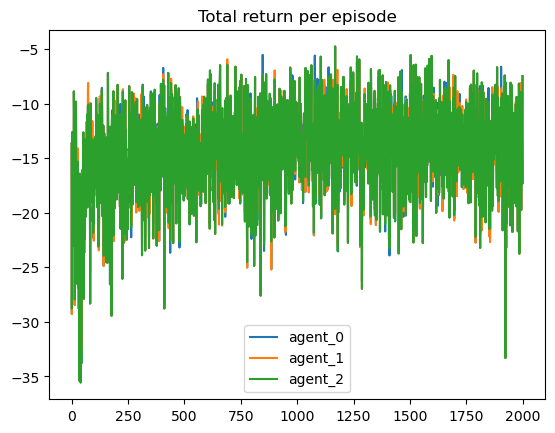

In [3]:
episode_returns = res['episode_returns']
for agent, returns in episode_returns.items():
    plt.plot(range(len(returns)), returns, label=f'{agent}')
plt.title('Total return per episode')
#plt.ylim(bottom=-50, top=0)
plt.legend()

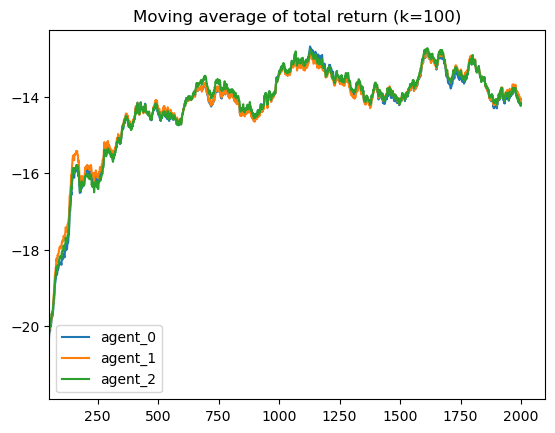

In [4]:
episode_returns = res['episode_returns']
for agent, returns in episode_returns.items():
    plt.plot(range(len(returns)), [np.mean(returns[max(0,x-100):x+1]) for x in range(len(returns))], label=f'{agent}')
plt.title('Moving average of total return (k=100)')
#plt.ylim(bottom=-50, top=0)
plt.xlim(left=50)
plt.legend()

In [5]:
from pettingzoo.mpe import simple_spread_v3
env = simple_spread_v3.env(max_cycles=25, continuous_actions=True, render_mode="human")
for _ in range(10):
    env.reset()
    ep_return = {agent : 0 for agent in env.possible_agents}
    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        ep_return[agent] += reward
        if termination or truncation:
            action = None
        else:
            # this is where you would insert your policy
            #action = env.action_space(agent).sample()
            action = res['best_model'][agent].select_action(observation)
        env.step(action)
    print(ep_return)
env.close()

{'agent_0': -23.218378853861978, 'agent_1': -21.218378853861978, 'agent_2': -23.218378853861978}
{'agent_0': -11.650245015505318, 'agent_1': -11.650245015505318, 'agent_2': -11.650245015505318}
{'agent_0': -15.35727267922298, 'agent_1': -14.35727267922298, 'agent_2': -13.857272679222978}
{'agent_0': -21.07860781456027, 'agent_1': -19.578607814560268, 'agent_2': -21.07860781456027}
{'agent_0': -18.438862642194792, 'agent_1': -17.438862642194792, 'agent_2': -18.438862642194792}
{'agent_0': -15.710123556748002, 'agent_1': -17.210123556748, 'agent_2': -17.210123556748}
{'agent_0': -13.818457264289869, 'agent_1': -13.818457264289869, 'agent_2': -13.818457264289869}
{'agent_0': -23.03642502963305, 'agent_1': -23.03642502963305, 'agent_2': -23.03642502963305}
{'agent_0': -18.750613857694283, 'agent_1': -18.750613857694283, 'agent_2': -18.750613857694283}
{'agent_0': -14.104845605045957, 'agent_1': -14.104845605045957, 'agent_2': -14.104845605045957}
